## Upload datasets

In [6]:
import pandas as pd
import numpy as np
train_dataset = pd.read_csv('train.csv')
train_dataset = train_dataset.sample(frac=1).reset_index(drop=True)
predict_dataset = pd.read_csv('test.csv')

train_dataset

,id,keyword,location,text,target
0,1572,bomb,NaN,The bomb was so appropriate ?? seen as my fami...,0
1,10546,windstorm,Georgia ? Tennessee,When I breathe it sounds like a windstorm. Hah...,0
2,10647,wounds,Kashmir!,Acc to the study conducted by SKIMS morethan 5...,1
3,5886,harm,"Massachusetts, USA",@tareksocal I think a lot of celebrities have ...,0
4,5284,fear,NaN,I want to be with you forever\nStay by my side...,0
5,6801,loud%20bang,NaN,#ActionMoviesTaughtUs things actually can expl...,0
6,3136,debris,"Berlin, Germany",Experts leave lab as Malaysia confirms debris ...,1
7,8817,sirens,miami x dallas,Lets Goooooooo http://t.co/fZ5eW4iHmB,0
8,2643,crashed,Kingswinford,I just nearly crashed my car typing 'Paul Rudd...,0
9,7580,outbreak,Anywhere,Families to sue over Legionnaires: More than 4...,1


In [7]:
train_dataset.count()
#The dataset (train and test) has 10876 lines, 7613 have the variable "target" (train) and 3263 are test data
#The variable keyword gives the theme of the tweet, it allows to categorize tweets, it is missing in some instances
#Text is the tweet, they are all in English, they contain many special characters that need to be removed
#Location is missing on a majority of instance

id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64

In [8]:
train_dataset.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

# Treatment of the "text" variable


In [9]:
#Extracting hashtags
import re
def extract_hashtags(dataset):
    hashtags = dataset['text'].str.extractall(r'#([A-Za-z0-9]+)')
    hashtags.index = hashtags.index.get_level_values(0)
    hashtags = hashtags.groupby([hashtags.index]).agg(lambda col: list(col))
    hashtags = hashtags.rename(columns={0:'hashtags'})
    dataset = dataset.merge(hashtags, how='left', left_index=True, right_index=True)
    return dataset

train_dataset = extract_hashtags(train_dataset)
predict_dataset = extract_hashtags(predict_dataset)

In [10]:
def normalize_text(string):
    string = string.lower()
    string = re.sub('http[\S]+', '', string)
    string = re.sub('[^\w\s]','', string)
    string = re.sub('[0-9]+', '', string)
    return string

In [11]:
train_dataset['text'] = train_dataset['text'].apply(lambda string : normalize_text(string))
predict_dataset['text'] = predict_dataset['text'].apply(lambda string : normalize_text(string))

# Tfidf vectorization and simple NN

In [8]:
#Spacy tokenization + Lemmatization + removing stop words

In [9]:
import spacy
nlp = spacy.load('en_core_web_md')
stop_words = nlp.Defaults.stop_words

def tokenize(string):
    tokens = nlp(string)
    tokens_nostop = ''
    for token in tokens:
        if token.text not in stop_words:
            tokens_nostop = tokens_nostop + ' ' + token.lemma_
    return tokens_nostop

In [9]:
train_dataset['text'] = train_dataset['text'].apply(lambda text: tokenize(text))
predict_dataset['text'] = predict_dataset['text'].apply(lambda text: tokenize(text))

In [10]:
# TfIdf Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df=2)
tfidf_vectorizer.fit(train_dataset['text'])

train_dataset_X = tfidf_vectorizer.transform(train_dataset['text']).toarray()
predict_dataset_X = tfidf_vectorizer.transform(predict_dataset['text']).toarray()

#y
train_dataset_y = np.array(train_dataset['target'])

In [11]:
#Split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_dataset_X, train_dataset_y, test_size=0.33, random_state=42)

# Logistic regression

In [100]:
#Model: simple logistic regression on tfidf features
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_test_predicted = classifier.predict(X_test)

C:\Users\jean_\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [101]:
#Performance metrics
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

accuracy = accuracy_score(y_test, y_test_predicted)
print('Accuracy is: '+ str(100*accuracy)+'%')

Accuracy is: 79.62594508555512%


In [102]:
confusion_matrix(y_test, y_test_predicted)

array([[1295,  127],
       [ 385,  706]], dtype=int64)

In [103]:
predict_dataset_predict_y = classifier.predict(predict_dataset_X)

In [104]:
prediction_df = pd.DataFrame(predict_dataset_predict_y, columns=['target'])

In [105]:
prediction_df = prediction_df.merge(predict_dataset[['id']], left_index=True, right_index=True)

In [106]:
prediction_df = prediction_df[['id','target']]
prediction_df.to_csv('submission1.csv', index=False)

In [107]:
#This submission got a result of 79.4%

(3263, 2)

# Neural network for classification

In [3]:
#Neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

from keras.optimizers import SGD
from keras.optimizers import Adam

model_nn = Sequential()
model_nn.add(Dense(300, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l1(0.0001)))

model_nn.add(Dense(300, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))

model_nn.add(Dense(1, activation='sigmoid'))

model_nn.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])

Using TensorFlow backend.


ModuleNotFoundError: No module named 'opt_einsum'

In [109]:
#Train model
training_process = model_nn.fit(X_train, y_train, epochs=500)

Epoch 1/500
5100/5100 [==============================] - 7s 1ms/step - loss: 19.6711 - accuracy: 0.4457
Epoch 2/500
5100/5100 [==============================] - 4s 791us/step - loss: 18.0249 - accuracy: 0.5167
Epoch 3/500
5100/5100 [==============================] - 4s 818us/step - loss: 16.4586 - accuracy: 0.5678
Epoch 4/500
5100/5100 [==============================] - 4s 813us/step - loss: 14.9721 - accuracy: 0.5722
Epoch 5/500
5100/5100 [==============================] - 4s 825us/step - loss: 13.5657 - accuracy: 0.5725 2s - loss: 13.9 - ETA: 1s - loss: 13.75
Epoch 6/500
5100/5100 [==============================] - 4s 843us/step - loss: 12.2397 - accuracy: 0.5725
Epoch 7/500
5100/5100 [==============================] - 4s 832us/step - loss: 10.9942 - accuracy: 0.5725 1
Epoch 8/500
5100/5100 [==============================] - 4s 841us/step - loss: 9.8291 - accuracy: 0.5725
Epoch 9/500
5100/5100 [==============================] - 4s 866us/step - loss: 8.7448 - accuracy: 0.5725
Epoch 10

KeyboardInterrupt: 

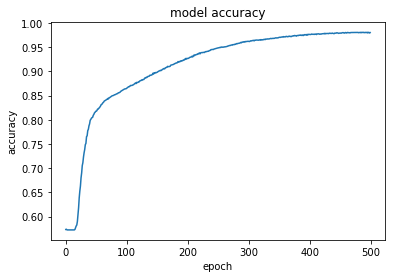

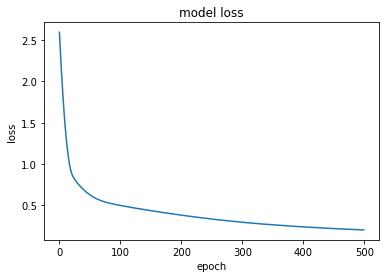

In [110]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(training_process.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(training_process.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [111]:
y_test_predicted = model_nn.predict(X_test)
y_test_predicted = np.where(y_test_predicted >= 0.5, 1, y_test_predicted)
y_test_predicted = np.where(y_test_predicted < 0.5, 0, y_test_predicted)

In [112]:
accuracy = accuracy_score(y_test, y_test_predicted)
print('Accuracy is: '+ str(100*accuracy)+'%')

Accuracy is: 56.585754078790295%


## RNN network

In [64]:
# Fit keras tokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 40
# This is fixed.
EMBEDDING_DIM = 50

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(train_dataset['text'].values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 17241 unique tokens.


In [65]:
#X variable
X_train_dataset = tokenizer.texts_to_sequences(train_dataset['text'].values)
X_predict_dataset = tokenizer.texts_to_sequences(predict_dataset['text'].values)

#The longest tweet has 31 tokens
X_train_dataset = pad_sequences(X_train_dataset, maxlen=MAX_SEQUENCE_LENGTH)
X_predict_dataset = pad_sequences(X_predict_dataset, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train_dataset.shape)

Shape of data tensor: (7613, 40)


In [66]:
#y variable
y_train_dataset = np.array(train_dataset['target'])

In [67]:
#Split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_dataset, y_train_dataset, test_size=0.33, random_state=42)

In [68]:
X_train_dataset.shape

(7613, 40)

In [82]:
#Model specification
from keras import Sequential
from keras.layers import Dense, SpatialDropout1D, LSTM, Embedding
from keras.optimizers import Adam
from keras import regularizers

model_rnn = Sequential()
model_rnn.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train_dataset.shape[1]))
model_rnn.add(SpatialDropout1D(0.3))
model_rnn.add(LSTM(EMBEDDING_DIM, dropout=0.3, recurrent_dropout=0.3))
model_rnn.add(Dense(40, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))
model_rnn.add(Dense(1, activation='sigmoid' , kernel_regularizer=regularizers.l2(0.01)))
model_rnn.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
model_rnn.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 40, 50)            500000    
_________________________________________________________________
spatial_dropout1d_28 (Spatia (None, 40, 50)            0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_52 (Dense)             (None, 40)                2040      
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 41        
Total params: 522,281
Trainable params: 522,281
Non-trainable params: 0
_________________________________________________________________


In [83]:
#fit the model
epochs = 50
batch_size = 300

history = model_rnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Train on 5100 samples, validate on 2513 samples
Epoch 1/100
5100/5100 [==============================] - 4s 799us/step - loss: 1.1473 - accuracy: 0.5692 - val_loss: 1.1415 - val_accuracy: 0.5726
Epoch 2/100
5100/5100 [==============================] - 2s 442us/step - loss: 1.1369 - accuracy: 0.5692 - val_loss: 1.1312 - val_accuracy: 0.5726
Epoch 3/100
5100/5100 [==============================] - 2s 437us/step - loss: 1.1270 - accuracy: 0.5692 - val_loss: 1.1215 - val_accuracy: 0.5726
Epoch 4/100
5100/5100 [==============================] - 2s 441us/step - loss: 1.1175 - accuracy: 0.5692 - val_loss: 1.1123 - val_accuracy: 0.5726
Epoch 5/100
5100/5100 [==============================] - 3s 518us/step - loss: 1.1084 - accuracy: 0.5692 - val_loss: 1.1034 - val_accuracy: 0.5726
Epoch 6/100
5100/5100 [==============================] - 2s 446us/step - loss: 1.0998 - accuracy: 0.5692 - val_loss: 1.0947 - val_accuracy: 0.5726
Epoch 7/100
5100/5100 [==============================] - 3s 492us/step

KeyboardInterrupt: 

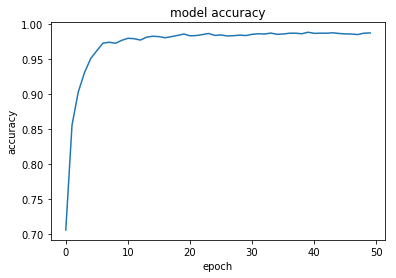

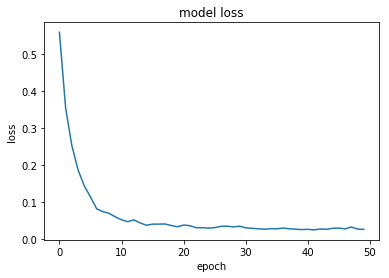

In [50]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [52]:
from sklearn.metrics import accuracy_score
y_test_predicted = model_rnn.predict(X_test)
y_test_predicted = np.where(y_test_predicted >= 0.5, 1, y_test_predicted)
y_test_predicted = np.where(y_test_predicted < 0.5, 0, y_test_predicted)
accuracy = accuracy_score(y_test, y_test_predicted)
print('Accuracy is: '+ str(100*accuracy)+'%')

Accuracy is: 74.01512136888182%


In [11]:
pip uninstall keras

^C
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install --upgrade --ignore-installed tensorflow-gpu==1.5

Note: you may need to restart the kernel to use updated packages.


  Could not find a version that satisfies the requirement tensorflow-gpu==1.5 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0rc0, 1.15.0rc1, 1.15.0rc2, 1.15.0rc3, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 2.0.0a0, 2.0.0b0, 2.0.0b1, 2.0.0rc0, 2.0.0rc1, 2.0.0rc2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.1.0rc0, 2.1.0rc1, 2.1.0rc2, 2.1.0, 2.1.1, 2.1.2, 2.2.0rc0, 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.2.1, 2.3.0rc0, 2.3.0rc1, 2.3.0rc2, 2.3.0, 2.3.1, 2.4.0rc0, 2.4.0rc1, 2.4.0rc2, 2.4.0rc3, 2.4.0rc4, 2.4.0)
No matching distribution found for tensorflow-gpu==1.5


In [1]:
import tensorflow

ImportError: Traceback (most recent call last):
  File "C:\Users\jean_\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\pywrap_tensorflow.py", line 64, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed: The specified module could not be found.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [2]:
`pip install tensorflow

SyntaxError: invalid syntax (<ipython-input-2-6f51f63b44a2>, line 1)

In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow

ImportError: cannot import name 'pywrap_tensorflow' from 'tensorflow.python' (C:\Users\jean_\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\__init__.py)

In [3]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.
